In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm
import numpy as np
from scipy.signal import find_peaks, butter, filtfilt

(1383364, 2)
2025-05-02 03:58:59.622000
2025-05-02 05:59:02.048000
(1283033, 2)


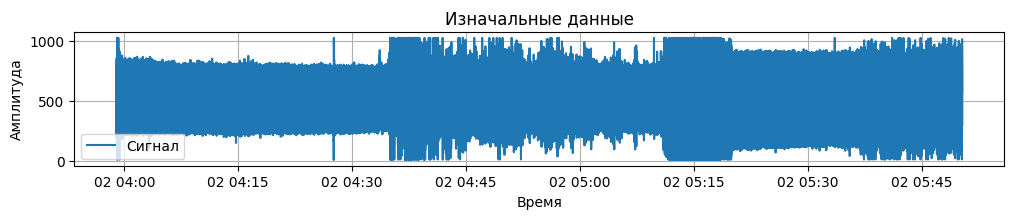

In [2]:
# Загрузка данных
data = pd.read_csv('com_data/com_data_20250502_035859_619.csv')
print(data.shape)
data.head()

# Копирование данных и преобразование времени
data = data.copy()
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
print(data['Timestamp'].min())
print(data['Timestamp'].max())

# Фильтрация данных по временному диапазону
filtered_data = data[(data['Timestamp'] > '2025-05-02 03:59:00') & 
                    (data['Timestamp'] < '2025-05-02 05:50:20')].reset_index(drop=True)

print(filtered_data.shape)

# Визуализация исходных данных
x = filtered_data['Timestamp']
y = filtered_data['COM_Data']

plt.figure(figsize=(12, 8))
plt.subplot(414)
plt.plot(x, y, label="Сигнал")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("Изначальные данные")
plt.legend()
plt.grid(True)
plt.show()

# создание регрессии

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

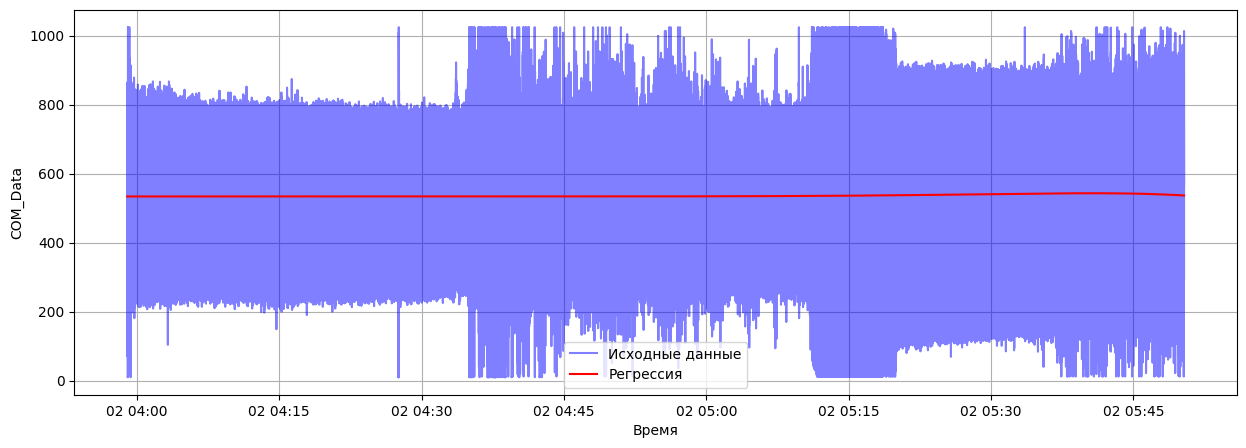

In [4]:
# Создание полиномиальных признаков
poly = PolynomialFeatures(degree=10, include_bias=False)
# Используем индексы как признак X вместо временных меток
X = np.arange(len(y)).reshape(-1, 1)
X_poly = poly.fit_transform(X)

# Обучение модели
model = LinearRegression()
# Обучаем на правильных данных: X_poly -> y (COM_Data)
model.fit(X_poly, y)

# Предсказание
y_pred = model.predict(X_poly)

# Визуализация
plt.figure(figsize=(15, 5))
plt.plot(filtered_data['Timestamp'], y, color='blue', alpha=0.5, label='Исходные данные')
plt.plot(filtered_data['Timestamp'], y_pred, color='red', label='Регрессия')
plt.xlabel('Время')
plt.ylabel('COM_Data')
plt.legend()
plt.grid(True)
plt.show()

# Определение пиков

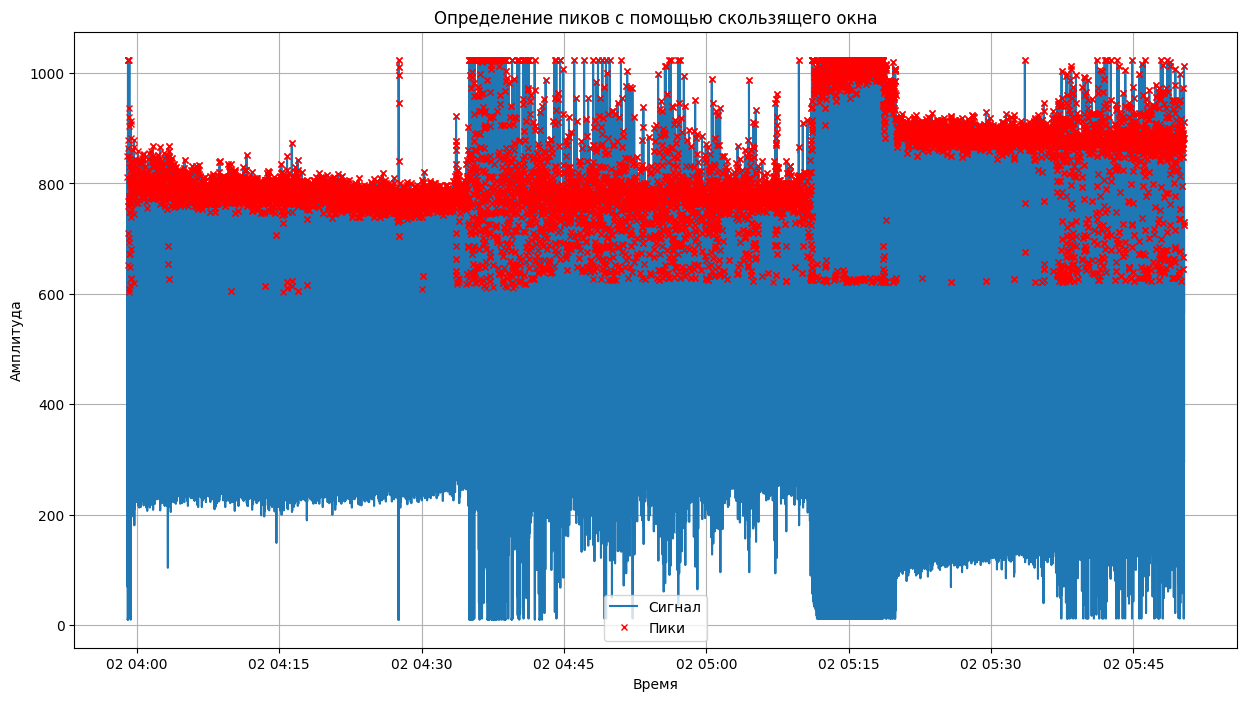

Найдено пиков: 16821


In [5]:
# Определение параметров окна
window_size = pd.Timedelta(minutes=5)
start_time = filtered_data['Timestamp'].min()
end_time = filtered_data['Timestamp'].max()

# Создаем список для хранения всех найденных пиков
all_peaks = []

# Проходим по данным окнами
current_time = start_time
while current_time < end_time:
    window_end = current_time + window_size
    
    # Выбираем данные для текущего окна
    mask = (filtered_data['Timestamp'] >= current_time) & (filtered_data['Timestamp'] < window_end)
    window_data = filtered_data[mask].copy()
    
    if not window_data.empty:
        # Создаем регрессию для окна
        X_window = np.arange(len(window_data)).reshape(-1, 1)
        X_poly_window = poly.fit_transform(X_window)
        model_window = LinearRegression()
        model_window.fit(X_poly_window, window_data['COM_Data'])
        y_pred_window = model_window.predict(X_poly_window)
        
        # Рассчитываем порог для поиска пиков (регрессия + 15%)
        threshold = y_pred_window + (y_pred_window * 0.15)
        mean_threshold = np.mean(threshold)
        
        # Ищем пики в окне
        window_peaks, _ = find_peaks(window_data['COM_Data'].values, 
                                   height=mean_threshold,
                                   distance=10,
                                   prominence=100)
        
        # Сохраняем индексы найденных пиков
        all_peaks.extend(window_data.index[window_peaks])
    
    # Сдвигаем окно (с перекрытием 50%)
    current_time += window_size / 2

# Преобразуем список пиков в массив numpy
peaks = np.array(all_peaks)
peaks.sort()

# Визуализация с пиками
plt.figure(figsize=(15, 8))
plt.plot(filtered_data['Timestamp'], filtered_data['COM_Data'], label="Сигнал")
plt.plot(filtered_data['Timestamp'][peaks], filtered_data['COM_Data'].iloc[peaks], 
         "x", color='red', label="Пики", markersize=5)
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("Определение пиков с помощью скользящего окна")
plt.legend()
plt.grid(True)
plt.show()

# Выводим количество найденных пиков
print(f"Найдено пиков: {len(peaks)}")

(15359, 2)


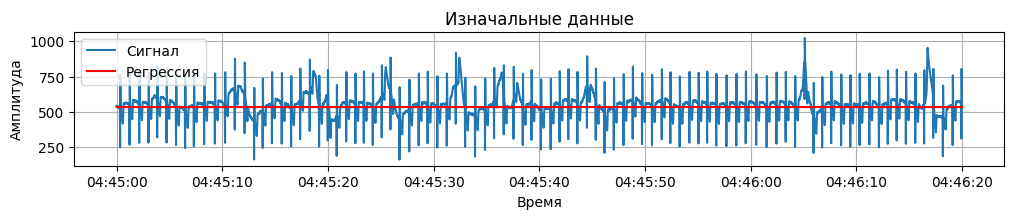

In [6]:
filtered_data__ = data[(data['Timestamp'] > '2025-05-02 04:45:00') & 
                    (data['Timestamp'] < '2025-05-02 04:46:20')].reset_index(drop=True)

print(filtered_data__.shape)

# Визуализация исходных данных
x_ = filtered_data__['Timestamp']
y_ = filtered_data__['COM_Data']

plt.figure(figsize=(12, 8))
plt.subplot(414)
plt.plot(x_, y_, label="Сигнал")
# Filter y_pred to match the indices of filtered_data__
start_idx = filtered_data__.index[0]
end_idx = filtered_data__.index[-1] + 1
plt.plot(filtered_data__['Timestamp'], y_pred[start_idx:end_idx], color='red', label='Регрессия')
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("Изначальные данные")
plt.legend()
plt.grid(True)
plt.show()

# Выявление аномалий

In [7]:
print(x[peaks])
for i in range(len(x[peaks]) - 1):
    time = pd.to_datetime(x[peaks].values)
    # Получаем полную разницу во времени в секундах
    interval = (time[i + 1] - time[i]).total_seconds()
    
    # Пересчитываем границы для BPM
    # 40 BPM = 1.5 сек между ударами
    # 150 BPM = 0.4 сек между ударами
    if not (0.4 < interval < 1.5):
        # Помечаем аномальный интервал
        mask = (filtered_data['Timestamp'] >= time[i]) & (filtered_data['Timestamp'] <= time[i + 1])
        filtered_data.loc[mask, 'COM_Data'] = None

80        2025-05-02 03:59:00.418
226       2025-05-02 03:59:01.179
351       2025-05-02 03:59:01.830
480       2025-05-02 03:59:02.502
624       2025-05-02 03:59:03.251
                    ...          
1282826   2025-05-02 05:50:18.920
1282893   2025-05-02 05:50:19.269
1282893   2025-05-02 05:50:19.269
1282997   2025-05-02 05:50:19.812
1282997   2025-05-02 05:50:19.812
Name: Timestamp, Length: 16821, dtype: datetime64[ns]


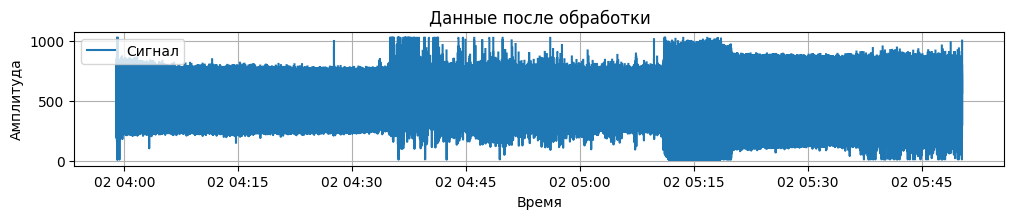

In [8]:
# Визуализация после обработки
x = filtered_data['Timestamp']
y = filtered_data['COM_Data']

plt.figure(figsize=(12, 8))
plt.subplot(414)
plt.plot(x, y, label="Сигнал")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("Данные после обработки")
plt.legend()
plt.grid(True)
plt.show()

Сохранение результатов

In [9]:
filtered_data.to_csv('com_data/com_fixed_data_20250502_035859_619.csv')

(5740, 2)


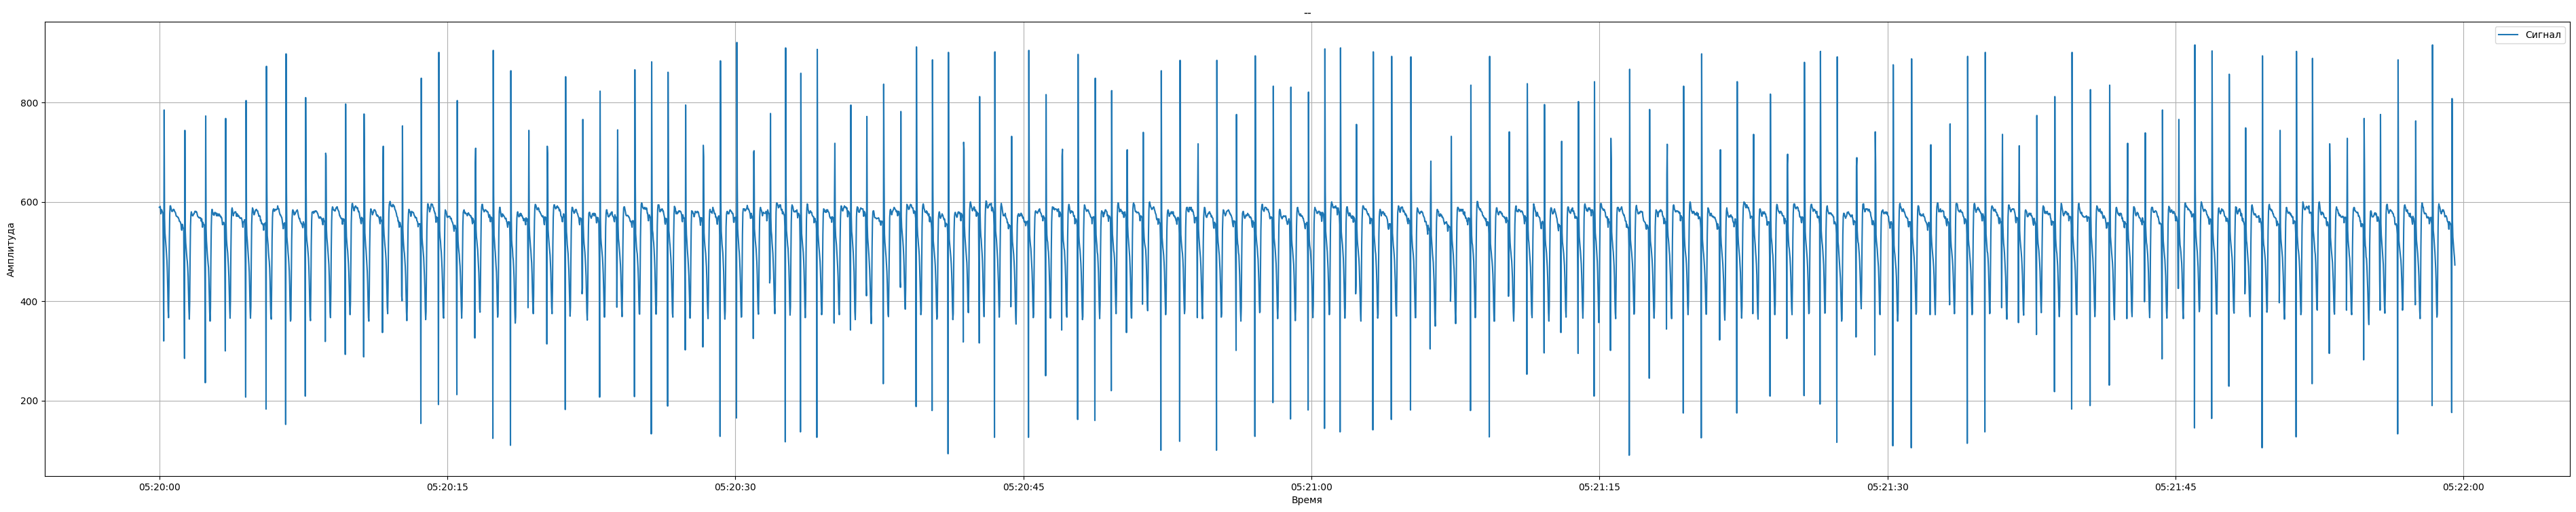

In [10]:
filtered_data1_ = data[(data['Timestamp'] > '2025-05-02 05:20:00') & 
                    (filtered_data['Timestamp'] < '2025-05-02 05:22:00')]
filtered_data1_ = filtered_data1_[0::4].reset_index(drop=True)
print(filtered_data1_.shape)

# Визуализация исходных данных
x = filtered_data1_['Timestamp']
y = filtered_data1_['COM_Data']

plt.figure(figsize=(48, 40))
plt.subplot(414)
plt.plot(x, y, label="Сигнал")
plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("--")
plt.legend()
plt.grid(True)
plt.show()

(2880, 2)


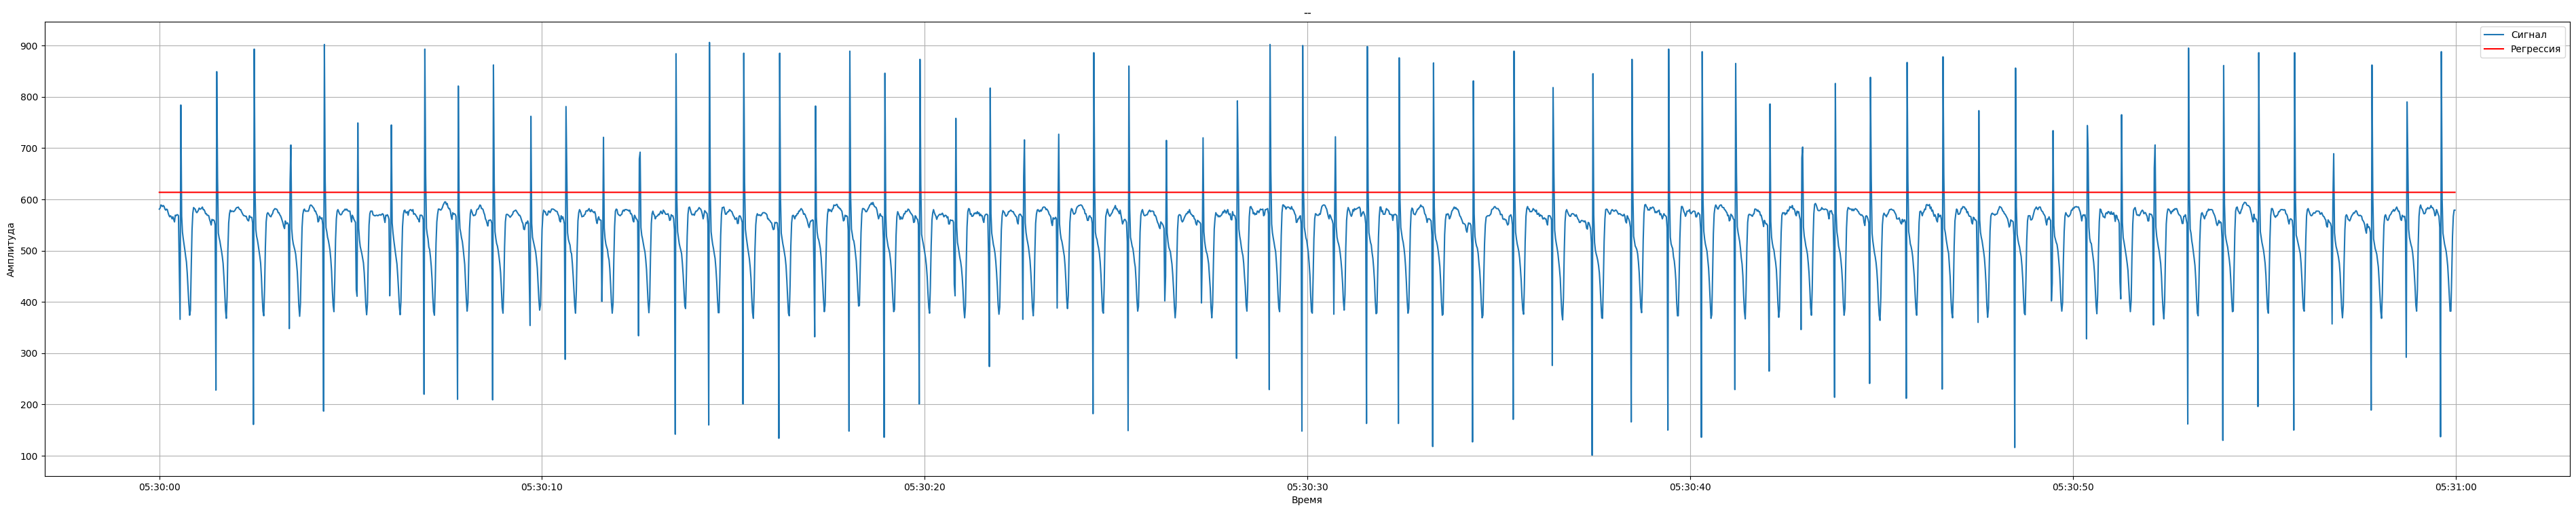

In [11]:
filtered_data1 = data[(data['Timestamp'] > '2025-05-02 05:30:00') & 
                    (data['Timestamp'] < '2025-05-02 05:31:00')]
filtered_data1 = filtered_data1[0::4].reset_index(drop=True)
print(filtered_data1.shape)

# Визуализация исходных данных
x = filtered_data1['Timestamp']
y = filtered_data1['COM_Data']

plt.figure(figsize=(48, 40))
plt.subplot(414)
plt.plot(x, y, label="Сигнал")
start_idx = filtered_data1.index[0]
end_idx = filtered_data1.index[-1] + 1
plt.plot(filtered_data1['Timestamp'], y_pred[start_idx:end_idx] + (y_pred[start_idx:end_idx] * 0.15), color='red', label='Регрессия')

plt.xlabel("Время")
plt.ylabel("Амплитуда")
plt.title("--")
plt.legend()
plt.grid(True)
plt.show()